<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch05/05_karaage_ai_book_pose_estimation_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 骨格推定

## 準備

In [1]:
!git clone https://github.com/karaage0703/tf-pose-estimation
%cd /content/tf-pose-estimation
!git checkout -b anime origin/anime

Cloning into 'tf-pose-estimation'...
remote: Enumerating objects: 1482, done.
remote: Total 1482 (delta 0), reused 0 (delta 0), pack-reused 1482
Receiving objects: 100% (1482/1482), 98.34 MiB | 40.20 MiB/s, done.
Resolving deltas: 100% (807/807), done.
/content/tf-pose-estimation
Branch 'anime' set up to track remote branch 'anime' from 'origin'.
Switched to a new branch 'anime'


必要なライブラリをセットアップ

In [2]:
!sudo apt-get install -y swig
%cd /content/tf-pose-estimation/tf_pose/pafprocess
!swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace
!pip3 install slidingwindow
%cd /content/tf-pose-estimation

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (751 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (T

TensorFlowを1.x系に切り替えてインポート

In [3]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


必要なライブラリをインポート

In [4]:
import argparse
import logging
import sys
import time

from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

import matplotlib.pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




姿勢推定する画像を読み込んで確認します。

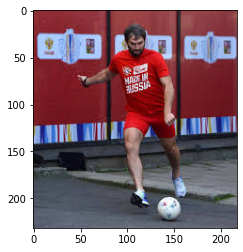

In [5]:
image = cv2.imread('./images/p1.jpg')
plt.imshow(image[:, :, ::-1])

画像から姿勢推定をします。

In [6]:
e = TfPoseEstimator(get_graph_path('mobilenet_v2_large'), target_size=(432, 368))
humans = e.inference(image, resize_to_default=1, upsample_size=4)
image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

[2020-10-22 15:33:24,082] [TfPoseEstimator] [INFO] loading graph from /content/tf-pose-estimation/models/graph/mobilenet_v2_large/graph_opt.pb(default size=432x368)
2020-10-22 15:33:24,082 INFO loading graph from /content/tf-pose-estimation/models/graph/mobilenet_v2_large/graph_opt.pb(default size=432x368)


2020-10-22 15:33:24,084 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:345: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



2020-10-22 15:33:24,087 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:346: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



2020-10-22 15:33:24,119 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:364: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2020-10-22 15:33:24,348 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:366: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



TfPoseEstimator/image
TfPoseEstimator/MobilenetV2/Conv/BatchNorm/Const
TfPoseEstimator/MobilenetV2/Conv/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv/depthwise/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv/depthwise/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv/project/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv/project/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/expand/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/expand/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/depthwise/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_1/project/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_1/project/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_2/expand/BatchNorm/Const
TfPoseEstimator/MobilenetV2/expanded_conv_2/expand/BatchNorm/Const_1
TfPoseEstimator/MobilenetV2/expanded_conv_2/depthwise/

2020-10-22 15:33:25,853 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:375: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2020-10-22 15:33:25,856 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:376: The name tf.image.resize_area is deprecated. Please use tf.compat.v1.image.resize_area instead.



2020-10-22 15:33:25,880 WARNING From /content/tf-pose-estimation/tf_pose/tensblur/smoother.py:96: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-10-22 15:33:25,911 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:388: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-10-22 15:33:25,918 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:393: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



2020-10-22 15:33:25,922 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:394: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2020-10-22 15:33:25,925 WARNING From /content/tf-pose-estimation/tf_pose/estimator.py:396: The name tf.report_uninitialized_variables is deprecated. Please use tf.compat.v1.report_uninitialized_variables instead.



姿勢推定結果を表示します。

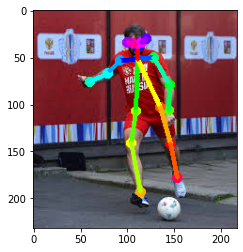

In [7]:
plt.imshow(image[:, :, ::-1])

## カメラ

Webカメラを使うJavascriptのコードをダウンロードします。

In [8]:
!wget https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/colab_camera.py

--2020-10-22 15:34:01--  https://raw.githubusercontent.com/karaage0703/karaage-ai-book/master/util/colab_camera.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3036 (3.0K) [text/plain]
Saving to: ‘colab_camera.py’

colab_camera.py     100%[===================>]   2.96K  --.-KB/s    in 0s      

2020-10-22 15:34:02 (54.4 MB/s) - ‘colab_camera.py’ saved [3036/3036]



コードを読み込みます。

In [9]:
import colab_camera

画像処理のコードを書きます

In [11]:
import IPython
from google.colab import output
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import base64

def run(img_str):
  #decode to image
  decimg = base64.b64decode(img_str.split(',')[1], validate=True)
  decimg = Image.open(BytesIO(decimg))
  decimg = np.array(decimg, dtype=np.uint8); 
  decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

  # pose estimation
  humans = e.inference(decimg, resize_to_default=1, upsample_size=4)
  out_img = TfPoseEstimator.draw_humans(decimg, humans, imgcopy=False)

  #encode to string
  _, encimg = cv2.imencode(".jpg", out_img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
  img_str = encimg.tostring()
  img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
  return IPython.display.JSON({'img_str': img_str})

output.register_callback('notebook.run', run)

In [ ]:
colab_camera.use_cam()

### アニメ化

顔を上書きする機能を準備します。

顔を上書きする関数(face overlay)を importします。

In [13]:
from tf_pose.estimator import face_overlay

顔に上書きするアイコンをダウンロードします。

In [14]:
!wget https://raw.githubusercontent.com/karaage0703/karaage_icon/master/karaage_icon.png

--2020-10-22 15:35:44--  https://raw.githubusercontent.com/karaage0703/karaage_icon/master/karaage_icon.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78311 (76K) [image/png]
Saving to: ‘karaage_icon.png.1’

karaage_icon.png.1  100%[===================>]  76.48K  --.-KB/s    in 0.02s   

2020-10-22 15:35:44 (4.38 MB/s) - ‘karaage_icon.png.1’ saved [78311/78311]



顔検出するための、ハールライク特徴量のデータファイルをダウンロードします。

In [15]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml

--2020-10-22 15:35:48--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676709 (661K) [text/plain]
Saving to: ‘haarcascade_frontalface_alt.xml’

haarcascade_frontal 100%[===================>] 660.85K  --.-KB/s    in 0.05s   

2020-10-22 15:35:48 (14.2 MB/s) - ‘haarcascade_frontalface_alt.xml’ saved [676709/676709]



cascadeモデルとしてハールライク特徴量を読み込みます

In [16]:
cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')

アニメ化する関数を定義します。

In [17]:
def run(img_str):
  #decode to image
  decimg = base64.b64decode(img_str.split(',')[1], validate=True)
  decimg = Image.open(BytesIO(decimg))
  decimg = np.array(decimg, dtype=np.uint8); 
  decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

  # pose estimation
  image_org = decimg.copy()
  humans = e.inference(decimg, resize_to_default=1, upsample_size=4)
  image_tmp = TfPoseEstimator.draw_humans(decimg, humans, imgcopy=False, mode='anime')
  out_img = face_overlay(image_org, image_tmp, cascade)

  #encode to string
  _, encimg = cv2.imencode(".jpg", out_img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
  img_str = encimg.tostring()
  img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
  return IPython.display.JSON({'img_str': img_str})

output.register_callback('notebook.run', run)

In [ ]:
colab_camera.use_cam()